In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image, ImageOps, ImageEnhance

import cv2
import albumentations as A
# from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET 
import shutil
from tqdm import tqdm
import time
import random


import os 
print(os.listdir('../data/generative-dog-images'))

['all-dogs.zip', 'Annotation.zip', 'all-dogs', 'Annotation']


In [2]:
TIME_LIMIT = 32400 - 60 * 10
start_time = time.time()

def elapsed_time(start_time):
    return time.time() - start_time

In [3]:
# random seeds
seed = 2019
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

BATCH_SIZE = 128
NUM_WORKERS = 4
EMA = False
LABEL_NOISE = False
LABEL_NOISE_PROB = 0.1

# Pre-Processing

In [4]:
PATH = '../data/generative-dog-images/all-dogs/all-dogs'
img_filnames = os.listdir(PATH)
len(img_filnames)

20579

In [5]:
PATH_ANNOTATION = '../data/generative-dog-images/Annotation/Annotation/'
breeds = glob.glob(PATH_ANNOTATION + '*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed + '/*')
len(annotations)

20580

In [6]:
breed_map = {}
for annotation in annotations:
    breed = annotation.split('/')[-2]
    index = breed.split('-')[0]
    breed_map.setdefault(index, breed)

n_classes = len(breed_map)
n_classes

120

In [7]:
breed_map

{'n02092002': 'n02092002-Scottish_deerhound',
 'n02099849': 'n02099849-Chesapeake_Bay_retriever',
 'n02091244': 'n02091244-Ibizan_hound',
 'n02095314': 'n02095314-wire-haired_fox_terrier',
 'n02091831': 'n02091831-Saluki',
 'n02102318': 'n02102318-cocker_spaniel',
 'n02104365': 'n02104365-schipperke',
 'n02090622': 'n02090622-borzoi',
 'n02113023': 'n02113023-Pembroke',
 'n02105505': 'n02105505-komondor',
 'n02099601': 'n02099601-golden_retriever',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02110063': 'n02110063-malamute',
 'n02086079': 'n02086079-Pekinese',
 'n02097130': 'n02097130-giant_schnauzer',
 'n02107142': 'n02107142-Doberman',
 'n02097209': 'n02097209-standard_schnauzer',
 'n02106662': 'n02106662-German_shepherd',
 'n02093754': 'n02093754-Border_terrier',
 'n02105251': 'n02105251-briard',
 'n02108551': 'n02108551-Tibetan_mastiff',
 'n02108422': 'n02108422-bull_mastiff',
 'n02093859': 'n02093859-Kerry_blue_terrier',
 'n02104029': 'n02104029-kuvasz',
 'n02107574': 'n02107574

In [8]:
# crop images using bounding box 
def bounding_box(img):
    bpath = PATH_ANNOTATION + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    bbxs = []
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box 
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbxs.append((xmin, ymin, xmax, ymax))
    return bbxs

In [9]:
def bounding_box_ratio(img):
    bpath = PATH_ANNOTATION + str(breed_map[img.split('_')[0]]) + '/' + str(img.split('.')[0])
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    bbx_ratios = []
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box 
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        xlen = xmax - xmin
        ylen = ymax - ymin
        ratio = ylen / xlen

        bbx_ratios.append((xlen, ylen, ratio))
    
    return bbx_ratios

In [10]:
%%time
# threshold for aspect ratio, at the same time idx for each bbx 
img_filnames_th = []
ratios_th = []
for img in tqdm(img_filnames):
    bbx_ratios = bounding_box_ratio(img)
    for i, (xlen, ylen, ratio) in enumerate(bbx_ratios):
        if ((ratio>0.2) & (ratio<4.0)):
            img_filnames_th.append(img[:-4] + '_' + str(i) + '.jpg')
            ratios_th.append(ratio)

ratios_th = np.array(ratios_th)

print('original:', len(img_filnames))
print('after th:', len(img_filnames_th))

100%|██████████| 20579/20579 [00:12<00:00, 1711.03it/s]

original: 20579
after th: 22119
CPU times: user 663 ms, sys: 302 ms, total: 965 ms
Wall time: 12 s


In [11]:
intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',
    
    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',
    
    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',
    
    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',
    
    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',
    
    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',
    
    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',
    
    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',
    
    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',
    
    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',
    
    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',
    
    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',
    
    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',
    
    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',
    
    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',
    
    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

len(intruders)

60

In [12]:
def data_preprocessing(img_path, bbx_idx):
    bbx = bounding_box(img_path)[bbx_idx]
    img = Image.open(os.path.join(PATH, img_path)) # PILImage format
    img_cropped = img.crop(bbx)
    return img_cropped

In [13]:
%%time 
breed_map_2 = {}
for i, b in enumerate(breed_map.keys()):
    breed_map_2[b] = i

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 16.5 µs


In [14]:
class DogDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        super().__init__()

        self.path = path
        self.img_list = img_list
        self.transform1 = transform1
        self.transform2 = transform2

        self.imgs = [] 
        self.labels = []
        for i, full_img_path in enumerate(self.img_list):
            if full_img_path in intruders:
                continue
            
            # img 
            img_path = full_img_path[:-6] + '.jpg'
            bbx_idx = int(full_img_path[-5])
            img = data_preprocessing(img_path, bbx_idx)
            if self.transform1:
                img = self.transform1(img) # output shape=(c, h, h, w)
            self.imgs.append(img)

            # label 
            label = breed_map_2[img_path.split('_')[0]]
            self.labels.append(label)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform2:
            img = self.transform2(img)
        label = self.labels[idx]

        return {'img':img, 'label':label}

In [15]:
%%time 
# generate 64x64 images!
img_size = 64
batch_size = BATCH_SIZE
MEAN1, MEAN2, MEAN3 = 0.5, 0.5, 0.5
STD1, STD2, STD3 = 0.5, 0.5, 0.5

transform1 = transforms.Compose([
    transforms.Resize(img_size)
])

transform2 = transforms.Compose([
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN1, MEAN2, MEAN3], std=[STD1, STD2, STD3])
])

train_set =  DogDataset(
    path=PATH,
    img_list=img_filnames_th,
    transform1=transform1,
    transform2=transform2,
)
train_loader = DataLoader(
    train_set, 
    shuffle=True, batch_size=batch_size,
    num_workers=NUM_WORKERS, pin_memory=True
)

CPU times: user 49 s, sys: 886 ms, total: 49.9 s
Wall time: 1min 16s


In [16]:
len(train_set)

22059

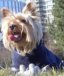

In [17]:
img = data_preprocessing(img_filnames_th[1500][:-6] + '.jpg', 0)
img = transform1(img)
img 

# Device

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
def conv3x3(in_channels, out_channels): # not change resolusion
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)

def conv1x1(in_channels, out_channels): # not change resolusion 
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    
    elif classname.find('Batch') != -1:
        m.weight.data.normal_(1, 0.02)
        m.bias.data.zero_()

    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()

    elif classname.find('Embedding') != -1:
        nn.init.orthogonal_(m.weight, gain=1)

class Attention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.theta = nn.utils.spectral_norm(conv1x1(channels, channels // 8)).apply(init_weight)
        self.phi = nn.utils.spectral_norm(conv1x1(channels, channels // 8)).apply(init_weight)

        self.g = nn.utils.spectral_norm(conv1x1(channels, channels // 2)).apply(init_weight)
        self.o = nn.utils.spectral_norm(conv1x1(channels // 2, channels)).apply(init_weight)

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, inputs):
        batch, c, h, w = inputs.size()

        theta = self.theta(inputs) # (*, c/8, h, w)
        phi = F.max_pool2d(self.phi(inputs), [2, 2]) # (*, c/8, h/2, w/2)
        g = F.max_pool2d(self.g(inputs), [2, 2]) # (*, c/2, h/2, w/2)

        theta = theta.view(batch, self.channels // 8, -1) # (*, c/8, h*w)
        phi = phi.view(batch, self.channels // 8, -1) # (*, c/8, h*w/4)
        g = g.view(batch, self.channels // 2, -1) # (*, c/2, h*w/4)

        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1) # (*, h*w, h*w/4)
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(batch, self.channels//2, h, w)) # (*, c, h, w)

        return self.gamma * o + inputs

class ConditionalNorm(nn.Module):
    def __init__(self, in_channel, n_condition):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channel, affine=False) # no learning parameters
        self.embed = nn.Linear(n_condition, in_channel * 2)

        nn.init.orthogonal_(self.embed.weight.data[:, :in_channel], gain=1)
        self.embed.weight.data[:, in_channel:].zero_()

    def forward(self, inputs, label):
        out = self.bn(inputs)
        embed = self.embed(label.float())
        gamma, beta = embed.chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta

        return out

In [21]:
# BigGAN + leaky_relu
class ResBlock_G(nn.Module):
    def __init__(self, in_channel, out_channel, condition_dim, upsample=True):
        super().__init__()
        self.cbn1 = ConditionalNorm(in_channel, condition_dim)
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample', nn.Upsample(scale_factor=2, mode='nearest'))

        self.conv3x3_1 = nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight)
        self.cbn2 = ConditionalNorm(out_channel, condition_dim)
        self.conv3x3_2 = nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight)
        self.conv1x1 = nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)

    def forward(self, inputs, condition):
        x = F.leaky_relu(self.cbn1(inputs, condition))
        x = self.upsample(x)
        x = self.conv3x3_1(x)
        x = self.conv3x3_2(F.leaky_relu(self.cbn2(x, condition)))
        x += self.conv1x1(self.upsample(inputs)) # shortcut
        return x 

class Generator(nn.Module):
    def __init__(self, n_feat, codes_dim=24, n_classes=n_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(codes_dim, 16*n_feat*4*4)).apply(init_weight)
        )
        self.res1 = ResBlock_G(16*n_feat, 16*n_feat, codes_dim+n_classes, upsample=True)
        self.res2 = ResBlock_G(16*n_feat, 8*n_feat, codes_dim+n_classes, upsample=True)
        self.res3 = ResBlock_G(8*n_feat, 4*n_feat, codes_dim+n_classes, upsample=True)
        
        self.attn = Attention(4*n_feat)

        self.res4 = ResBlock_G(4*n_feat, 2*n_feat, codes_dim+n_classes, upsample=True)

        self.conv = nn.Sequential(
            nn.LeakyReLU(),
            nn.utils.spectral_norm(conv3x3(2*n_feat, 3)).apply(init_weight)
        )

    def forward(self, z, label_ohe, codes_dim=24):
        '''
        z.shape = (*, 120)
        label_ohe.shape = (*, n_classes)

        Args:
            z ([type]): [description]
            label_ohe ([type]): [description]
            codes_dim (int, optional): [description]. Defaults to 24.
        '''
        batch = z.size(0)
        z = z.squeeze()
        label_ohe = label_ohe.squeeze()
        codes = torch.split(z, codes_dim, dim=1)

        x = self.fc(codes[0]) # (*, 16ch*4*4)
        x = x.view(batch, -1, 4, 4) # (*, 16ch, 4, 4)

        condition = torch.cat([codes[1], label_ohe], dim=1) # (codes_dim+n_classes)
        x = self.res1(x, condition) # (*, 16ch, 8, 8)

        condition = torch.cat([codes[2], label_ohe], dim=1)
        x = self.res2(x, condition) # (*, 8ch, 16, 16)

        condition = torch.cat([codes[3], label_ohe], dim=1)
        x = self.res3(x, condition) # (*, 4ch, 32, 32)
        x = self.attn(x) # not change shape

        condition = torch.cat([codes[4], label_ohe], dim=1)
        x = self.res4(x, condition) # (*, 2ch, 64, 64)
        
        x = self.conv(x) # (*, 3, 64, 64)
        x = torch.tanh(x)
        return x

In [22]:
class ResBlock_D(nn.Module):
    def __init__(self, in_channel, out_channel, downsample=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight)
        )

        self.shortcut = nn.Sequential(
            nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)
        )
        
        if downsample:
            self.layer.add_module('avgpool', nn.AvgPool2d(kernel_size=2, stride=2))
            self.shortcut.add_module('avgpool', nn.AvgPool2d(kernel_size=2, stride=2))

    def forward(self, inputs):
        x = self.layer(inputs)
        x += self.shortcut(inputs)
        return x 

class Discriminator(nn.Module):
    def __init__(self, n_feat, n_classes=n_classes):
        super().__init__()
        self.res1 = ResBlock_D(3, n_feat, downsample=True)
        self.attn = Attention(n_feat)
        self.res2 = ResBlock_D(n_feat, 2*n_feat, downsample=True)
        self.res3 = ResBlock_D(2*n_feat, 4*n_feat, downsample=True)
        self.res4 = ResBlock_D(4*n_feat, 8*n_feat, downsample=True)
        self.res5 = ResBlock_D(8*n_feat, 16*n_feat, downsample=False)

        self.fc = nn.utils.spectral_norm(nn.Linear(16*n_feat, 1)).apply(init_weight)
        self.embedding = nn.Embedding(num_embeddings=n_classes, embedding_dim=16*n_feat).apply(init_weight)

    def forward(self, inputs, label):
        batch = inputs.size(0) # (*, 3, 64, 64)
        h = self.res1(inputs) # (*, ch, 32, 32)
        h = self.attn(h) # not change shape
        h = self.res2(h) # (*, 2ch, 16, 16)
        h = self.res3(h) # (*, 4ch, 8, 8)
        h = self.res4(h) # (*, 8ch, 4, 4)
        h = self.res5(h) # (*, 16ch, 4, 4)
        h = torch.sum((F.leaky_relu(h, 0.2)).view(batch, -1, 4*4), dim=2) # GlobalSumPool (*, 16ch)

        outputs = self.fc(h) # (*, 1)

        if label is not None:
            embed = self.embedding(label) # (*, 16ch)
            outputs += torch.sum(embed*h, dim=1, keepdim=True) # (*, 1)

        outputs = torch.sigmoid(outputs)
        return outputs

In [23]:
# BigGAN
print(count_parameters(model=Generator(n_feat=27, codes_dim=24, n_classes=n_classes))) # z.shape = (*, 120)
print(count_parameters(model=Discriminator(n_feat=33, n_classes=n_classes)))

6089851
5259641


# Train

In [24]:
def generate_img(netG, fixed_noise, fixed_aux_labels=None):
    if fixed_aux_labels is not None:
        gen_image = netG(fixed_noise, fixed_aux_labels).to('cpu').clone().detach().squeeze(0)
    else:
        gen_image = netG(fixed_noise).to('cpu').clone().detach().squeeze(0)

    # denormalize 
    gen_image = gen_image * 0.5 + 0.5
    gen_image_numpy = gen_image.numpy().transpose(0, 2, 3, 1)
    return gen_image_numpy

def show_generate_imgs(netG, fixed_noise, fixed_aux_labels=None):
    gen_images_numpy = generate_img(netG, fixed_noise, fixed_aux_labels)

    fig = plt.figure(figsize=(25,16))
    # display 10 images from each class 
    for i, img in enumerate(gen_images_numpy):
        ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
        plt.imshow(img)
    plt.show()
    plt.close()

In [25]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [26]:
# BigGAN
def run(lr_G = 3e-4, lr_D = 3e-4, beta1 = 0.0, beta2 = 0.999, nz=120, epochs=2, n_ite_D=1, ema_decay_rate=0.999, show_epoch_list=None, output_freq = 10):
    netG = Generator(n_feat=36, codes_dim=24, n_classes=n_classes).to(device) # z.shape=(*, 120)
    netD = Discriminator(n_feat=42, n_classes=n_classes).to(device)

    if EMA:
        # EMA of G for sampling 
        netG_EMA = Generator(n_feat=42, codes_dim=24, n_classes=n_classes).to(device)
        netG_EMA.load_state_dict(netG.state_dict())
        for p in netG_EMA.parameters():
            p.requires_grad = False

    print(count_parameters(netG))
    print(count_parameters(netD))

    real_label = 0.9
    fake_label = 0

    D_loss_list = []
    G_loss_list = []

    dis_criterion = nn.BCELoss().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))

    fixed_noise = torch.randn(32, nz, 1, 1, device=device)

    fixed_aux_labels = np.random.randint(0, n_classes, 32)
    fixed_aux_labels_ohe = np.eye(n_classes)[fixed_aux_labels]
    fixed_aux_labels_ohe = torch.from_numpy(fixed_aux_labels_ohe[:, :, np.newaxis, np.newaxis])
    fixed_aux_labels_ohe = fixed_aux_labels_ohe.float().to(device, non_blocking=True)

    netG.train()
    netD.train()

    # training here 
    for epoch in range(1, epochs+1):
        if elapsed_time(start_time) > TIME_LIMIT:
            print(f'elapsed_time go beyond {TIME_LIMIT} sec')
            break
        D_running_loss = 0
        G_running_loss = 0
        
        for ii, data in enumerate(train_loader):
            # update D network 
            for _ in range(n_ite_D):

                if LABEL_NOISE:
                    real_label = 0.9
                    fake_label = 0
                    if np.random.random() < LABEL_NOISE_PROB:
                        real_label = 0
                        fake_label = 0.9

                # train with real 
                netD.zero_grad()
                real_images = data['img'].to(device, non_blocking=True)
                batch_size = real_images.size(0)
                dis_labels = torch.full((batch_size, 1), real_label, device=device) # (*, )
                aux_labels = data['label'].long().to(device, non_blocking=True) # (*, )
                dis_output = netD(real_images, aux_labels) # dis shape (*, 1)

                errD_real = dis_criterion(dis_output, dis_labels)
                errD_real.backward(retain_graph=True)

                # train with fake 
                noise = torch.randn(batch_size, nz, 1, 1, device=device)

                aux_labels = np.random.randint(0, n_classes, batch_size)
                aux_labels_ohe = np.eye(n_classes)[aux_labels]
                aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:, :, np.newaxis, np.newaxis])
                aux_labels_ohe = aux_labels_ohe.float().to(device=device, non_blocking=True)

                aux_labels = torch.from_numpy(aux_labels).long().to(device=device, non_blocking=True)

                fake = netG(noise, aux_labels_ohe) # (*, 3, 64,64)

                dis_labels.fill_(fake_label)
                dis_output = netD(fake.detach(), aux_labels)
                
                errD_fake = dis_criterion(dis_output, dis_labels)
                errD_fake.backward(retain_graph=True)

                D_running_loss += (errD_real.item() + errD_fake.item()) / len(train_loader)
                optimizerD.step()

            # update G network
            netG.zero_grad()
            dis_labels.fill_(real_label) # fake labels are real for generator cost 
            noise = torch.randn(batch_size, nz, 1, 1, device=device)

            aux_labels = np.random.randint(0, n_classes, batch_size)
            aux_labels_ohe = np.eye(n_classes)[aux_labels]
            aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:, :, np.newaxis, np.newaxis])
            aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
            
            aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)

            fake = netG(noise, aux_labels_ohe)

            dis_output = netD(fake, aux_labels)
            errG = dis_criterion(dis_output, dis_labels)
            errG.backward(retain_graph=True)
            
            G_running_loss += errG.item() / len(train_loader)
            optimizerG.step()

        if EMA:
            # update netG_EMA
            param_itr = cycle(netG.parameters())
            for i, p_EMA in enumerate(netG_EMA.parameters()):
                p = next(param_itr)
                p_EMA.data = (1-ema_decay_rate) * p_EMA.data + ema_decay_rate * p.data
                p_EMA.requires_grad = False

        # log 
        D_loss_list.append(D_running_loss)
        G_loss_list.append(G_running_loss)

        # output 
        if epoch % output_freq == 0:
            print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = {:.1f} min'.format(epoch,epochs,D_running_loss,G_running_loss,elapsed_time(start_time)/60))

        if epoch in show_epoch_list:
            print('epoch = {}'.format(epoch))
            if not EMA:
                show_generate_imgs(netG,fixed_noise,fixed_aux_labels_ohe)
            elif EMA:
                show_generate_imgs(netG_EMA,fixed_noise,fixed_aux_labels_ohe)

        if epoch % 100 == 0:
            if not EMA:
                torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
            elif EMA:
                torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')
        
    if not EMA:
        torch.save(netG.state_dict(), 'generator.pth')
    elif EMA:
        torch.save(netG_EMA.state_dict(), 'generator.pth')
    torch.save(netD.state_dict(), 'discriminator.pth')

    res = {'netG':netG,
            'netD':netD,
            'nz':nz,
            'fixed_noise':fixed_noise,
            'fixed_aux_labels_ohe':fixed_aux_labels_ohe,
            'D_loss_list':D_loss_list,
            'G_loss_list':G_loss_list,
            }
    if EMA:
        res['netG_EMA'] = netG_EMA
    
    return res

In [27]:
%%time 
show_epoch_list = np.arange(0, 500+10, 10)

res = run(lr_G=3e-4,lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=500, 
          n_ite_D=1, ema_decay_rate=None, show_epoch_list=show_epoch_list, output_freq=10)

10491625
8497274


/home/xchen/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 23.70 GiB total capacity; 21.62 GiB already allocated; 44.56 MiB free; 22.01 GiB reserved in total by PyTorch)

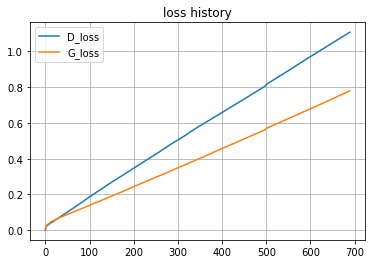

In [ ]:
plt.plot(res['D_loss_list'], label='D_loss')
plt.plot(res['G_loss_list'], label='G_loss')
plt.grid()
plt.legend()
plt.title('loss history');